In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev
import numpy as np

from unseen import process_utils
from unseen import eva

Matplotlib is building the font cache; this may take a moment.


In [2]:
ds = xr.open_dataset('/g/data/xv83/dbi599/tc-jasper/rx5day_AGCD-CSIRO_r005_1900-2023_A-AUG_daintree-river.nc')

In [3]:
ds = ds.isel({'time': slice(1,125)})

In [4]:
df = ds.to_dataframe()
df.index = df.index.year

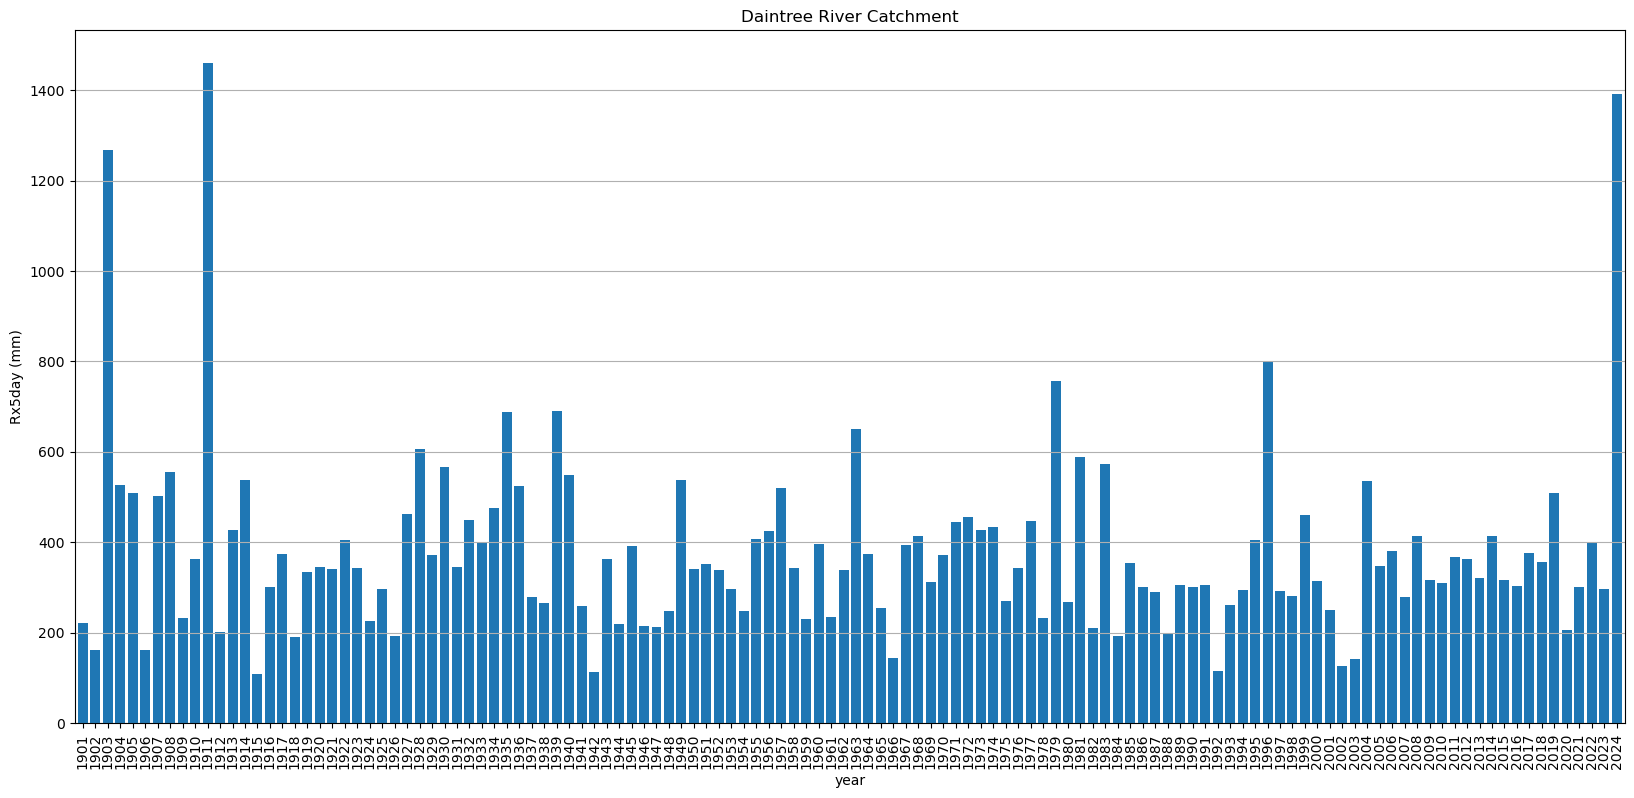

In [5]:
df['pr'].plot.bar(figsize=[20, 9], width=0.8)
plt.ylabel('Rx5day (mm)')
plt.xlabel('year')
plt.title('Daintree River Catchment')
plt.grid(axis='y')
plt.show()

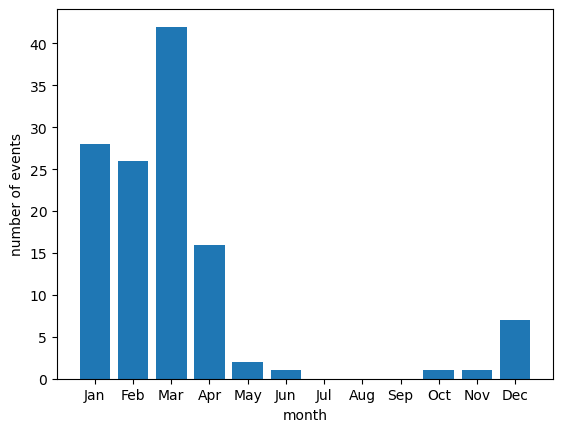

In [10]:
process_utils.plot_event_seasonality(df)

In [6]:
ranked_years = df.sort_values(by='pr', ascending=False)
print(ranked_years.head(n=10))

               pr  event_time
time                         
1911  1459.442017  1911-04-03
2024  1392.098877  2023-12-18
1903  1267.950684  1903-04-23
1996   799.335449  1996-03-08
1979   756.700500  1979-01-05
1939   689.864258  1939-03-25
1935   688.977478  1935-03-04
1963   650.727356  1963-04-10
1928   607.283936  1928-02-29
1981   589.572449  1981-01-13


According to the [BoM Queensland Flood history](http://www.bom.gov.au/qld/flood/fld_history/floodsum_1910.shtml):
"1st April: Heavy rain in north Queensland. Record floods at Palmerville and Walsh River; big loss of stock. On the 1st, 2nd, and 3rd the Barron River was in flood at Kuranda; flood estimated to be the highest on record."

In [7]:
rx5day_2023 = ranked_years.iloc[1]['pr']

In [8]:
rx5day_2023

1392.0989

In [9]:
gev23_shape, gev23_loc, gev23_scale = eva.fit_gev(ds['pr'].values, user_estimates=[-0.11, 293.6, 122.19])
gev22_shape, gev22_loc, gev22_scale = eva.fit_gev(ds['pr'].values[:-1], user_estimates=[-0.07, 293, 122])

In [10]:
print(gev23_shape, gev23_loc, gev23_scale)
print(gev22_shape, gev22_loc, gev22_scale)

-0.11454837453226169 293.6193598218641 122.18103434306002
-0.0778988051057505 293.42998816246364 119.50335401594131


In [11]:
gev.fit(ds['pr'].values, loc=293, scale=122)

(-0.11456176709753531, 293.62019772300346, 122.19504208387724)

/home/599/dbi599/unseen/unseen/eva.py:260: UserWarning: Data fit failed.
  warnings.warn("Data fit failed.")
/home/599/dbi599/unseen/unseen/eva.py:450: RuntimeWarning: divide by zero encountered in double_scalars
  boot_event_return_period = 1.0 / boot_event_probability
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


484 year return period
95% CI: 4-52903 years


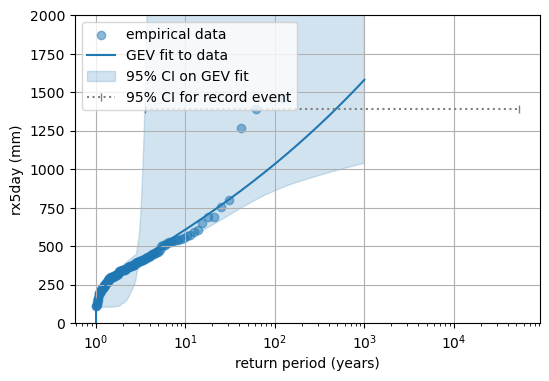

In [12]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot()
eva.plot_gev_return_curve(
    ax,
    ds['pr'].values,
    rx5day_2023,
    n_bootstraps=100,
    direction="exceedance",
    ylabel='rx5day (mm)',
    ylim=(0, 2000),
    max_return_period=3,
    user_estimates=[gev23_shape, gev23_loc, gev23_scale]
)
plt.show()

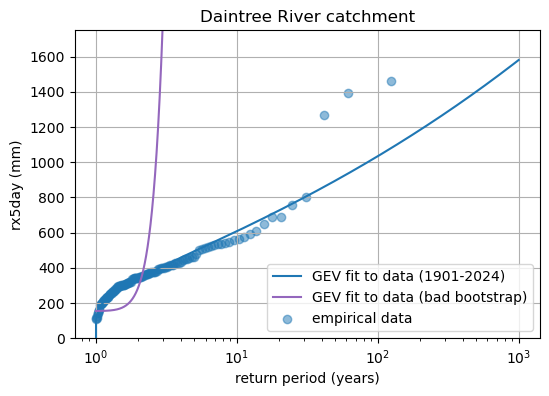

In [13]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot()

curve_return_periods = np.logspace(0, 3, num=10000)
curve_probabilities = 1.0 / curve_return_periods
#curve_values22 = gev.isf(curve_probabilities, gev22_shape, gev22_loc, gev22_scale)
#ax.plot(
#    curve_return_periods,
#    curve_values22,
#    color="tab:orange",
#    label="GEV fit to data (1901-2023)",
#)
curve_values23 = gev.isf(curve_probabilities, gev23_shape, gev23_loc, gev23_scale)
ax.plot(
    curve_return_periods,
    curve_values23,
    color="tab:blue",
    label="GEV fit to data (1901-2024)",
)
curve_values = gev.isf(curve_probabilities, -4.713150718807995, 178.35553150445844, 113.41111601089096)
ax.plot(
    curve_return_periods,
    curve_values,
    color="tab:purple",
    label="GEV fit to data (bad bootstrap)",
)

empirical_return_values = np.sort(ds['pr'].values, axis=None)[::-1]
empirical_return_periods = len(ds['pr'].values) / np.arange(1.0, len(ds['pr'].values) + 1.0)
ax.scatter(
    empirical_return_periods,
    empirical_return_values,
    color="tab:blue",
    alpha=0.5,
    label="empirical data",
)

ax.set_xscale("log")
ax.set_xlabel("return period (years)")
ax.set_ylabel("rx5day (mm)")
ax.set_ylim(0, 1750)
ax.grid()
ax.legend()
ax.set_title('Daintree River catchment')

plt.show()

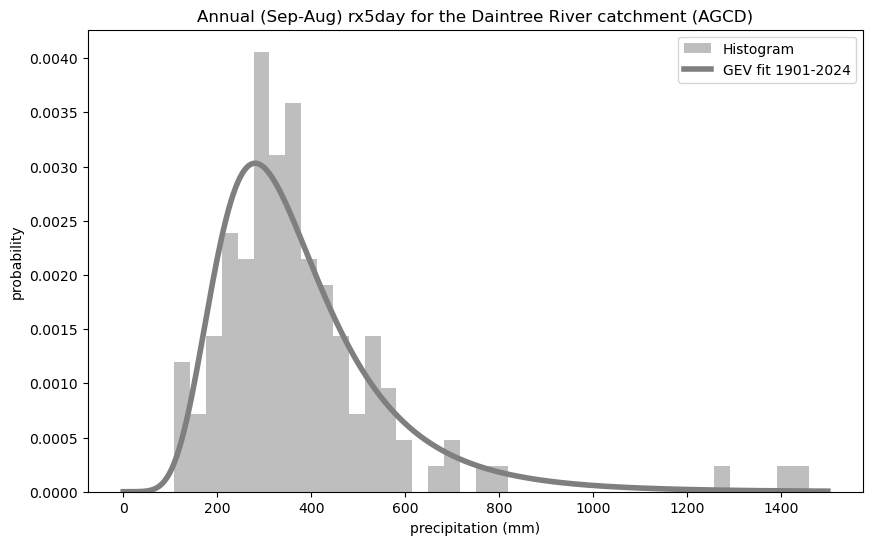

# Full timeseries (1901-2024)
483.731 year return period
99.79% percentile



In [16]:
fig, ax = plt.subplots(figsize=[10, 6])
gev_xvals = np.arange(0, 1500)
ds['pr'].plot.hist(bins=40, density=True, color='tab:gray', alpha=0.5, label='Histogram')
gev23_pdf = gev.pdf(gev_xvals, gev23_shape, gev23_loc, gev23_scale)
plt.plot(gev_xvals, gev23_pdf, color='tab:gray', linewidth=4.0, label='GEV fit 1901-2024')
#gev22_pdf = gev.pdf(gev_xvals, gev22_shape, gev22_loc, gev22_scale)
#plt.plot(gev_xvals, gev22_pdf, color='black', linewidth=4.0, linestyle=':', label='GEV fit 1901-2023')
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) rx5day for the Daintree River catchment (AGCD)')
#plt.xlim(0, 500)
plt.legend()
#plt.savefig(
#    '/g/data/xv83/dbi599/tc-jasper/figures/rx5day_histogram_AGCD_daintree-river.png',
#    bbox_inches='tight',
#    facecolor='white',
#)
plt.show()
    
event23_probability = gev.sf(rx5day_2023, gev23_shape, loc=gev23_loc, scale=gev23_scale)
event23_return_period = 1. / event23_probability
event23_percentile = (1 - event23_probability) * 100
print('# Full timeseries (1901-2024)')
print(f'{event23_return_period:.3f} year return period')
print(f'{event23_percentile:.2f}% percentile\n')
    
#event22_probability = gev.sf(rx5day_2023, gev22_shape, loc=gev22_loc, scale=gev22_scale)
#event22_return_period = 1. / event22_probability
#event22_percentile = (1 - event22_probability) * 100
#print('# No record timeseries (1901-2023)')
#print(f'{event22_return_period:.3f} year return period')
#print(f'{event22_percentile:.2f}% percentile')

## Meteorology of the most extreme events

### 5-day aggregates

In [ ]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    #plt.savefig(
    #    f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
    #    bbox_inches='tight',
    #    facecolor='white',
    #    dpi=300
    #)
    plt.show()

In [ ]:
z500_files = glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/zg500/v20231001/zg500_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc')
z500_files.sort()

pr_files = glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20231001/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc')
pr_files.sort()

psl_files = glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/psl/v20231001/psl_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc')
psl_files.sort()

ua300_files = glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/ua300/v20231001/ua300_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc')
ua300_files.sort()

In [ ]:
z500_ds = xr.open_mfdataset(z500_files)
pr_ds = xr.open_mfdataset(pr_files)
psl_ds = xr.open_mfdataset(psl_files)
ua300_ds = xr.open_mfdataset(ua300_files)

In [ ]:
for index, row in ranked_events.head(n=3).iterrows():
    end_date = row['event_time']
    if int(end_date[0:4]) > 1979:
        rx_value = row['pr']
        print(f'{index} ({end_date}): {rx_value}mm')
        start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
        start_date = start_datetime.strftime("%Y-%m-%d")
        z500_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
        pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
        pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
        psl_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        psl_da = xc.units.convert_units_to(psl_da, 'hPa')
        ua300_da = ua300_ds.sel({'time': slice(start_date, end_date)})['ua300']

        z500_da_mean = z500_da.mean('time', keep_attrs=True)
        pr_da_sum = pr_da.sum('time', keep_attrs=True)
        psl_da_mean = psl_da.mean('time', keep_attrs=True)
        ua300_da_mean = ua300_da.mean('time', keep_attrs=True)    

        plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
        plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
        plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)